In [1]:
import scanpy as sc
import graph_tool.all as gt
import scnsbm
import pickle
import pandas as pd
import anndata
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Equilibrate True

In [24]:
tdata = pd.read_table("../benchmarking_data/GSE133542_MARSseq_human_exp_mat.tsv.gz", compression='gzip')
adata = anndata.AnnData(tdata.T)
metadata = pd.read_table("../benchmarking_data/GSE133542_MARSseq_human_metada.tsv.gz", compression='gzip')

In [25]:
markers = pd.read_excel('../benchmarking_data/41587_2020_469_MOESM4_ESM.xlsx', skiprows=2)
cols = markers.columns
cols = [x.replace(' ', '_') for x in cols]
cols = [x.replace('+', '') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace('_cell', '') for x in cols]
markers.columns = cols

In [26]:
hca_annot = pd.read_table("../benchmarking_data/HCA_annotations.txt")

cells = [x for x in hca_annot.query('batch == "MARS-Seq"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)



Trying to set attribute `.obs` of view, copying.


filtered out 9980 genes that are detected in less than 5 cells


In [27]:
import mygene
mg = mygene.MyGeneInfo()

In [28]:

ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24428...done.
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
107 input query terms found no hit:
	['ENSG00000116883', 'ENSG00000163009', 'ENSG00000167945', 'ENSG00000168078', 'ENSG00000189144', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


In [29]:
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        

In [30]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
import scipy.stats
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

Trying to set attribute `.obs` of view, copying.


normalizing counts per cell
    finished (0:00:00)


/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']


/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical


    finished (0:00:15)


In [31]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.umap(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


In [32]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


In [11]:
scnsbm.inference.nested_model(adata, random_seed=42, equilibrate=True, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:02:35)
running MCMC equilibration step
    calculating cell affinity to groups
    finished (1:15:17)


In [12]:
scnsbm.io.write(adata, prefix='MARSseq')

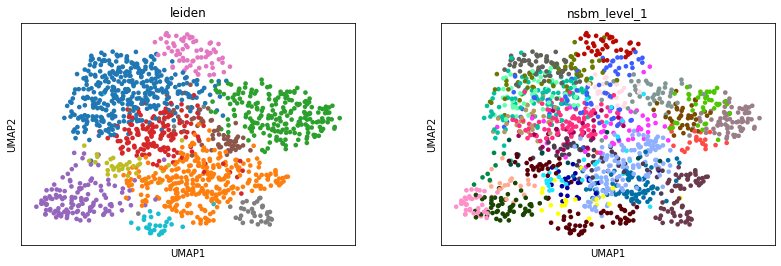

In [16]:
sc.pl.umap(adata, color=["leiden",'nsbm_level_1'], legend_loc='on_data')

In [19]:
adata=sc.read('MARSseq.h5ad')
astate=pickle.load(open('MARSseq.pkl','rb'))

In [23]:
adata.write('state_adata/MARSseq_equilibrate.h5ad')
pickle.dump(astate,open('state_adata/MARSseq_equilibrate.pkl','wb'),2)

In [2]:
adatae=sc.read('state_adata/MARSseq_equilibrate.h5ad')
estate=pickle.load(open('state_adata/MARSseq_equilibrate.pkl','rb'))

# Equilibrate False

In [33]:
scnsbm.inference.nested_model(adata, random_seed=42, equilibrate=False, steps_anneal=3, n_init=3)

minimizing the nested Stochastic Block Model
    done (0:02:46)
    calculating cell affinity to groups
    finished (0:02:49)


In [34]:
scnsbm.io.write(adata, prefix='MARSseq')

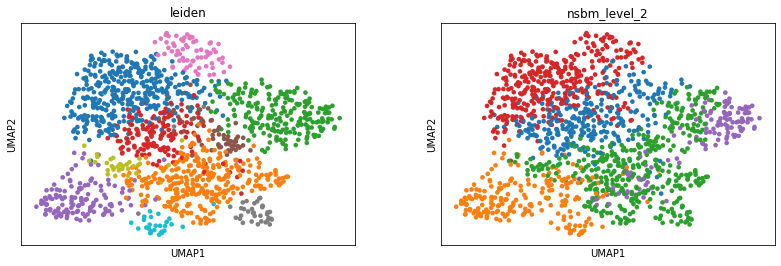

In [35]:
sc.pl.umap(adata, color=["leiden",'nsbm_level_2'], legend_loc='on_data')

In [36]:
adata=sc.read('MARSseq.h5ad')
astate=pickle.load(open('MARSseq.pkl','rb'))

In [41]:
adata.write('state_adata/MARSseq_minimize.h5ad')
pickle.dump(astate,open('state_adata/MARSseq_minimize.pkl','wb'),2)

In [3]:
adatam=sc.read('state_adata/MARSseq_minimize.h5ad')
mstate=pickle.load(open('state_adata/MARSseq_minimize.pkl','rb'))

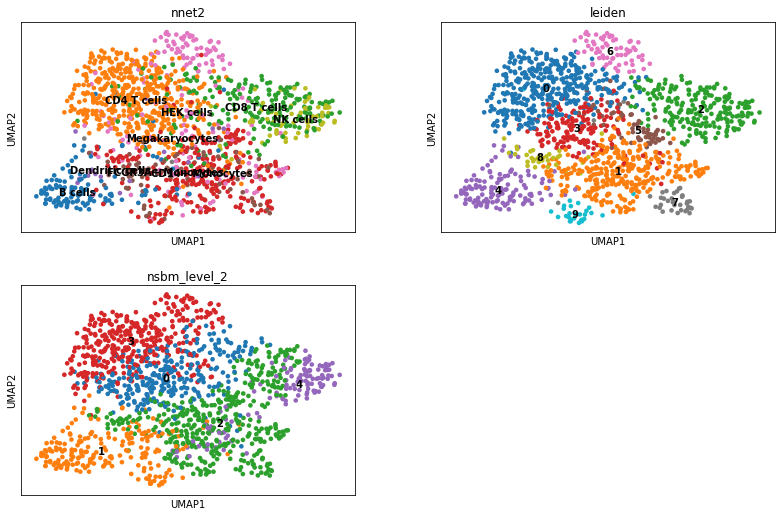

In [59]:
sc.pl.umap(adatam, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

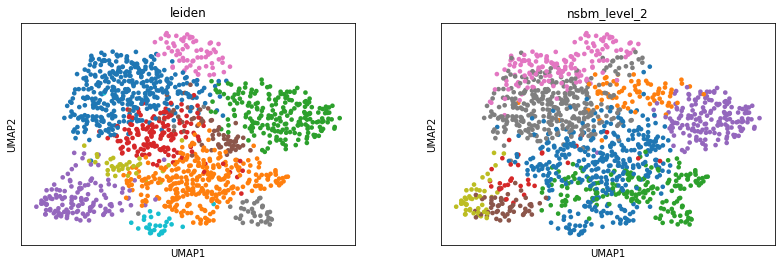

In [50]:
sc.pl.umap(adatae, color=["leiden",'nsbm_level_2'], legend_loc='on_data')

# PAGA

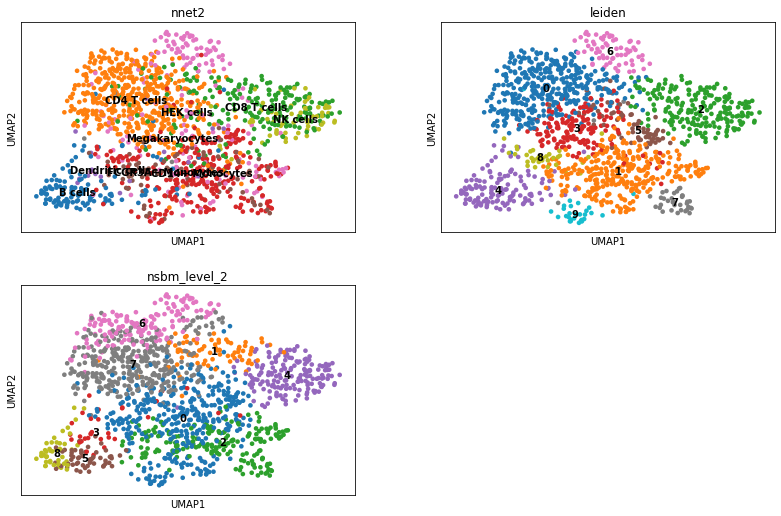

In [62]:
sc.pl.umap(adatae, color=['nnet2', 'leiden', 'nsbm_level_2'], ncols=2, legend_loc='on data')

paga leiden


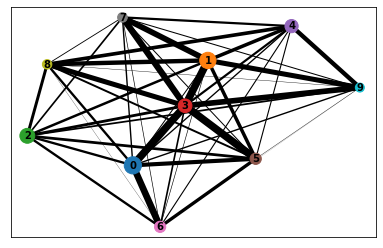

paga nsbm


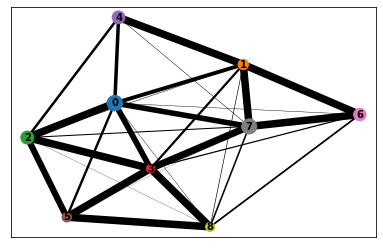

paga nnet2


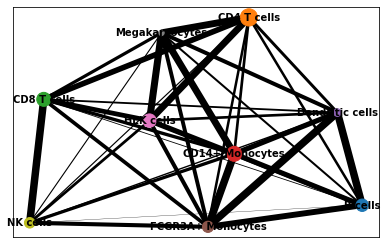

In [4]:
print('paga leiden')
sc.tl.paga(adatae,groups='leiden')
sc.pl.paga(adatae, color=['leiden'])
print('paga nsbm')
sc.tl.paga(adatae,groups='nsbm_level_2')
sc.pl.paga(adatae, color=['nsbm_level_2'])
print('paga nnet2')
sc.tl.paga(adatae,groups='nnet2')
sc.pl.paga(adatae, color=['nnet2'])

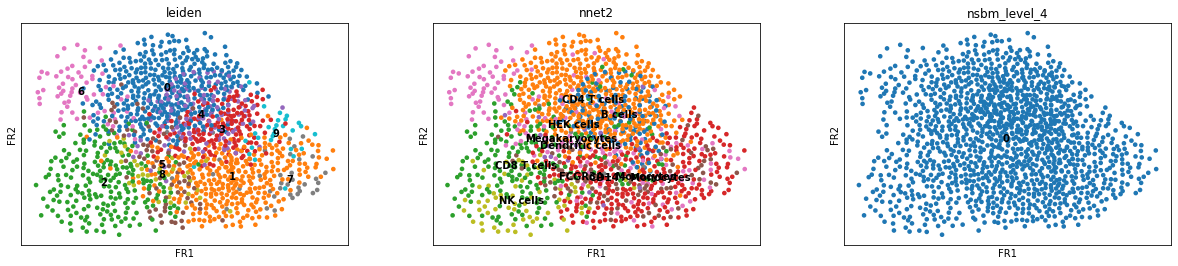

In [5]:
sc.tl.paga(adatae,groups='nnet2')
sc.tl.draw_graph(adatae, init_pos='paga')
sc.pl.draw_graph(adatae, color=['leiden', 'nnet2', 'nsbm_level_4'], legend_loc='on data')

paga leiden


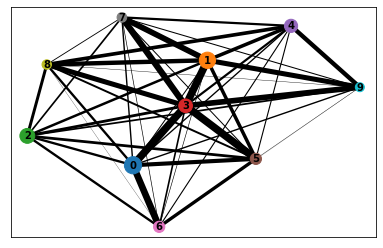

paga nsbm


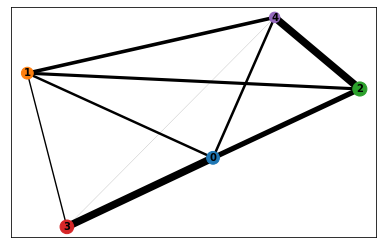

paga nnet2


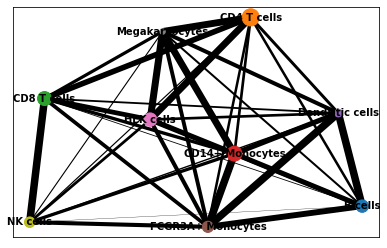

In [6]:
print('paga leiden')
sc.tl.paga(adatam,groups='leiden')
sc.pl.paga(adatam, color=['leiden'])
print('paga nsbm')
sc.tl.paga(adatam,groups='nsbm_level_2')
sc.pl.paga(adatam, color=['nsbm_level_2'])
print('paga nnet2')
sc.tl.paga(adatam,groups='nnet2')
sc.pl.paga(adatam, color=['nnet2'])

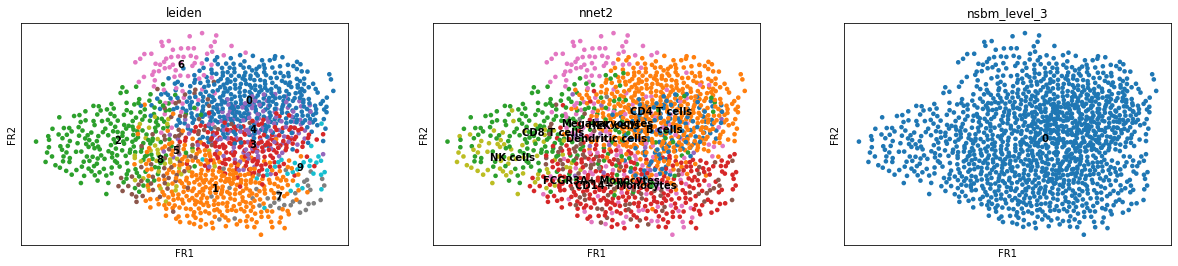

In [7]:
sc.tl.paga(adatam,groups='nnet2')
sc.tl.draw_graph(adatam, init_pos='paga')
sc.pl.draw_graph(adatam, color=['leiden', 'nnet2', 'nsbm_level_3'], legend_loc='on data')

In [8]:
adatam.write('state_adata/MARSseq_minimize.h5ad')
adatae.write('state_adata/MARSseq_equilibrate.h5ad')

In [2]:
adatam=sc.read('state_adata/MARSseq_minimize.h5ad')
adatae=sc.read('state_adata/MARSseq_equilibrate.h5ad')

In [10]:
adatam

AnnData object with n_obs × n_vars = 1401 × 7120 
    obs: 'nnet2', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6', 'nsbm_level_7', 'nsbm_level_8', 'nsbm_level_9'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'draw_graph', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'nnet2_colors', 'nnet2_sizes', 'nsbm', 'nsbm_level_2_colors', 'nsbm_level_2_sizes', 'nsbm_level_3_colors', 'paga', 'pca', 'umap'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_umap'
    varm: 'PCs'

# Marginals

In [4]:
E=adatae.uns['nsbm']['cell_affinity']['2']
adatae.obs['max_u'] = 1 - np.max(E, axis=1) 

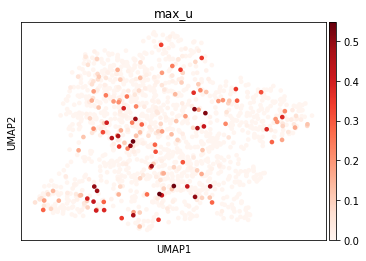

In [5]:
sc.pl.umap(adatae, color ='max_u',color_map='Reds')

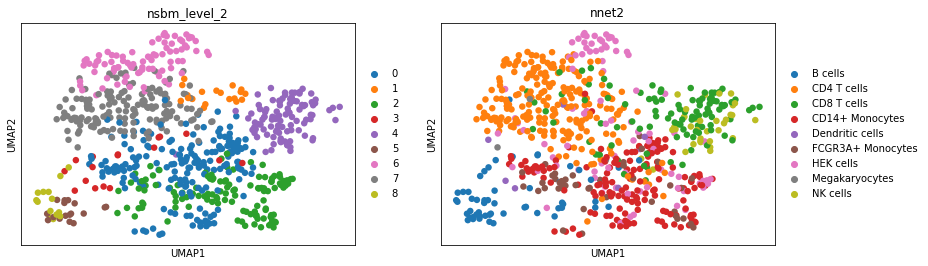

In [14]:
sc.pl.umap(adatae[adatae.obs.max_u < 1e-5], color=['nsbm_level_2','nnet2'])